In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
import shutil

In [3]:
from google.colab import files
files.upload()  # Select the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manyuak","key":"ecebd4141c72a73e883395350704de18"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d danielmao2019/deepfakeart

Dataset URL: https://www.kaggle.com/datasets/danielmao2019/deepfakeart
License(s): CC0-1.0
100% 31.3G/31.3G [07:23<00:00, 106MB/s] 
100% 31.3G/31.3G [07:23<00:00, 75.8MB/s]


In [6]:
!unzip deepfakeart.zip -d deepfakeart

Streaming output truncated to the last 5000 lines.
  inflating: deepfakeart/similar/style_transfer/Fauvism/120_edges.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/120_generated.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/120_original.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/121_edges.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/121_generated.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/121_original.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/122_edges.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/122_generated.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/122_original.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/123_edges.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/123_generated.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/123_original.png  
  inflating: deepfakeart/similar/style_transfer/Fauvism/1

In [7]:
# Define dataset path
DATASET_PATH = "/content/deepfakeart"

In [8]:
# Function to create the CNN model
def create_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(128, 128, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Load dataset
def load_dataset():
    image_pairs = []

    for category, json_path in [("similar", "/similar/test_similar.json"),
                                ("dissimilar", "/dissimilar/test_dissimilar.json")]:
        with open(DATASET_PATH + json_path, "r") as f:
            data = json.load(f)

            if category == "similar":
                # Iterate over each sub-category (inpainting, style_transfer, etc.)
                for sub_category in data:
                    for entry in data[sub_category].values():
                        image_pairs.append((
                            os.path.join(DATASET_PATH, entry["original"]),
                            os.path.join(DATASET_PATH, entry["generated"]),
                            1  # Label for similar
                        ))

            elif category == "dissimilar":
                for pair in data.get("original", {}).values():
                    image_pairs.append((
                        os.path.join(DATASET_PATH, pair["image_0"]),
                        os.path.join(DATASET_PATH, pair["image_1"]),
                        0  # Label for dissimilar
                    ))

    print(f"Loaded {len(image_pairs)} image pairs.")
    return image_pairs


In [10]:
# Preprocess images
def preprocess_images(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

In [11]:
# Load and split dataset
image_pairs = load_dataset()
X_data, y_data = [], []

for img1, img2, label in image_pairs:
    X_data.append(img1)
    X_data.append(img2)
    y_data.append(label)
    y_data.append(label)

X_data = preprocess_images(X_data)
y_data = np.array(y_data)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

Loaded 4585 image pairs.


In [12]:
image_pairs = load_dataset()
print(f"Total similar pairs: {sum(1 for pair in image_pairs if pair[2] == 1)}")
print(f"Total dissimilar pairs: {sum(1 for pair in image_pairs if pair[2] == 0)}")

Loaded 4585 image pairs.
Total similar pairs: 3618
Total dissimilar pairs: 967


In [13]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7944 - loss: 0.5548 - val_accuracy: 0.7863 - val_loss: 0.4974
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.7834 - loss: 0.5162 - val_accuracy: 0.7863 - val_loss: 0.4976
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.7956 - loss: 0.4936 - val_accuracy: 0.7863 - val_loss: 0.4786
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.7894 - loss: 0.4894 - val_accuracy: 0.7857 - val_loss: 0.4778
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.7952 - loss: 0.4709 - val_accuracy: 0.7852 - val_loss: 0.4727
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.7969 - loss: 0.4546 - val_accuracy: 0.7884 - val_loss: 0.4830
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8120 - loss: 0.4152 - val_accuracy: 0.7917 - val_loss: 0.4869
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.8201 - loss: 0.3940 - val_accu

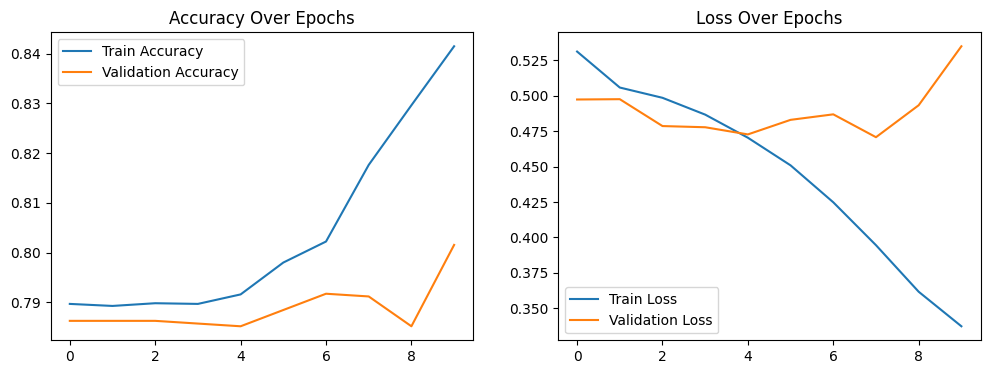

In [14]:
# Step 5: Visualize training results
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.show()

In [15]:
# Model summary as a table
from tabulate import tabulate

model_summary = []
for layer in model.layers:
    model_summary.append([layer.name, str(layer.output.shape), layer.count_params])

print(tabulate(model_summary, headers=["Layer Name", "Output Shape", "Param Count"], tablefmt="grid"))

+-----------------+----------------------+--------------------------------------------------------------------------------------+
| Layer Name      | Output Shape         | Param Count                                                                          |
+=================+======================+======================================================================================+
| conv2d          | (None, 126, 126, 32) | <bound method Layer.count_params of <Conv2D name=conv2d, built=True>>                |
+-----------------+----------------------+--------------------------------------------------------------------------------------+
| max_pooling2d   | (None, 63, 63, 32)   | <bound method Layer.count_params of <MaxPooling2D name=max_pooling2d, built=True>>   |
+-----------------+----------------------+--------------------------------------------------------------------------------------+
| conv2d_1        | (None, 61, 61, 64)   | <bound method Layer.count_params of <Conv2D nam

In [16]:
# Prediction function
def predict_similarity(img1, img2):
    img1_array = preprocess_images([img1])[0]
    img2_array = preprocess_images([img2])[0]
    prediction = model.predict(np.array([img1_array, img2_array]))
    return "Similar" if prediction[0] > 0.5 else "Dissimilar"

In [17]:
# Display images and prediction
def show_images_and_prediction(img1, img2, label):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.title("Image 1")
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis('off')
    plt.title("Image 2")
    plt.suptitle(f"Prediction: {'Similar' if label == 1 else 'Dissimilar'}", fontsize=14, fontweight="bold")
    plt.show()

In [18]:
def get_random_pair(label=None):
    similar_pairs = [pair for pair in image_pairs if pair[2] == 1]
    dissimilar_pairs = [pair for pair in image_pairs if pair[2] == 0]

    print(f"Debug: {len(similar_pairs)} similar pairs, {len(dissimilar_pairs)} dissimilar pairs")

    if label == 1 and similar_pairs:
        return random.choice(similar_pairs)
    elif label == 0 and dissimilar_pairs:
        return random.choice(dissimilar_pairs)
    elif label is None and image_pairs:
        return random.choice(image_pairs)

    print("Error: No image pairs found for the given label!")
    return None  # Explicitly return None if no pairs are found

Debug: 3618 similar pairs, 967 dissimilar pairs


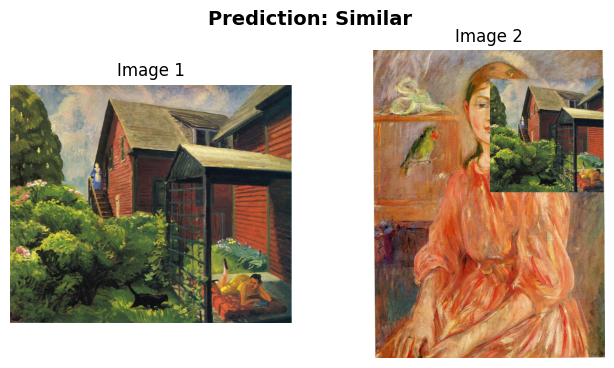

In [88]:
# Compare similar images
result = get_random_pair(1)
if result:
    img1_path, img2_path, label = result
    img1, img2 = Image.open(img1_path), Image.open(img2_path)
    show_images_and_prediction(img1, img2, label)
else:
    print("No similar image pairs available. Please check the dataset!")

Debug: 3618 similar pairs, 967 dissimilar pairs


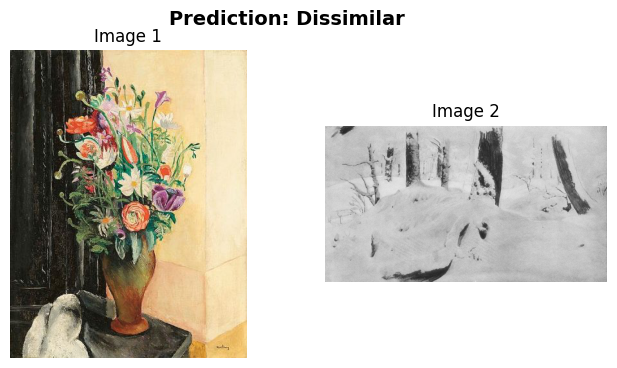

In [89]:
# Compare dissimilar images
result = get_random_pair(0)
if result:
    img1_path, img2_path, label = result
    img1, img2 = Image.open(img1_path), Image.open(img2_path)
    show_images_and_prediction(img1, img2, label)
else:
    print("No similar image pairs available. Please check the dataset!")

Debug: 3618 similar pairs, 967 dissimilar pairs


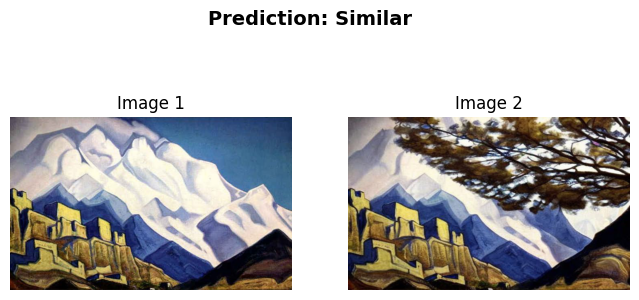

In [90]:
# Compare random images
img1_path, img2_path, label = get_random_pair()
img1, img2 = Image.open(img1_path), Image.open(img2_path)
show_images_and_prediction(img1, img2, label)

Button(description='Upload & Compare Images', style=ButtonStyle())

Please upload two images to compare...


Saving unnamed.png to unnamed (1).png
Saving Blossom-surreal-digital-art-by-Mario-Nevado.webp to Blossom-surreal-digital-art-by-Mario-Nevado (1).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


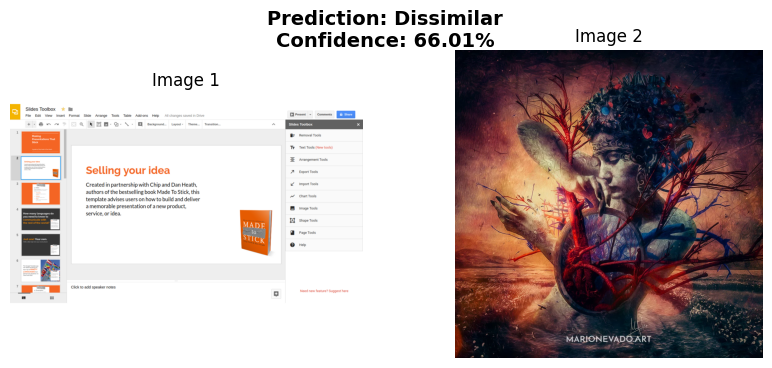

In [81]:
def preprocess_uploaded_image(img_path):
    """Preprocess single image for prediction"""
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0,1]
    return img_array

def predict_uploaded_images(img1_path, img2_path, model):
    """Make prediction on two uploaded images with 96% threshold"""
    # Preprocess both images
    img1_array = preprocess_uploaded_image(img1_path)
    img2_array = preprocess_uploaded_image(img2_path)

    # Make prediction
    predictions = model.predict(np.array([img1_array, img2_array]))
    confidence = predictions[0][0]

    # Use 96% threshold for similarity
    if confidence > 0.96:
        result = "Similar"
    else:
        result = "Dissimilar"

    return result, confidence

def show_comparison(img1, img2, result, confidence):
    """Display images and prediction"""
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.title("Image 1")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis('off')
    plt.title("Image 2")

    plt.suptitle(f"Prediction: {result}\nConfidence: {confidence:.2%}",
                 fontsize=14, fontweight="bold")
    plt.show()

def upload_and_compare():
    """Upload and compare two images"""
    print("Please upload two images to compare...")
    uploaded = files.upload()

    if len(uploaded) != 2:
        print("Error: Please upload exactly two images!")
        return

    # Get uploaded image paths
    img_paths = list(uploaded.keys())

    # Open images for display
    img1 = Image.open(img_paths[0])
    img2 = Image.open(img_paths[1])

    # Make prediction
    result, confidence = predict_uploaded_images(img_paths[0], img_paths[1], model)

    # Show results
    show_comparison(img1, img2, result, confidence)

# Create and display upload button
from ipywidgets import widgets
upload_button = widgets.Button(description="Upload & Compare Images")
upload_button.on_click(lambda x: upload_and_compare())
display(upload_button)